# 2. Data exploration

## Preparations
Import required libaries and load fitted and cleaned data from first notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

from datetime import datetime, date, time, timedelta

import seaborn as sns
from scipy import stats 
import statsmodels.api as sms
import statsmodels.formula.api as smf

%matplotlib inline

In [2]:
df = pd.read_csv('data/df_cleaned.csv')

## Data exploration

#### Data distribution

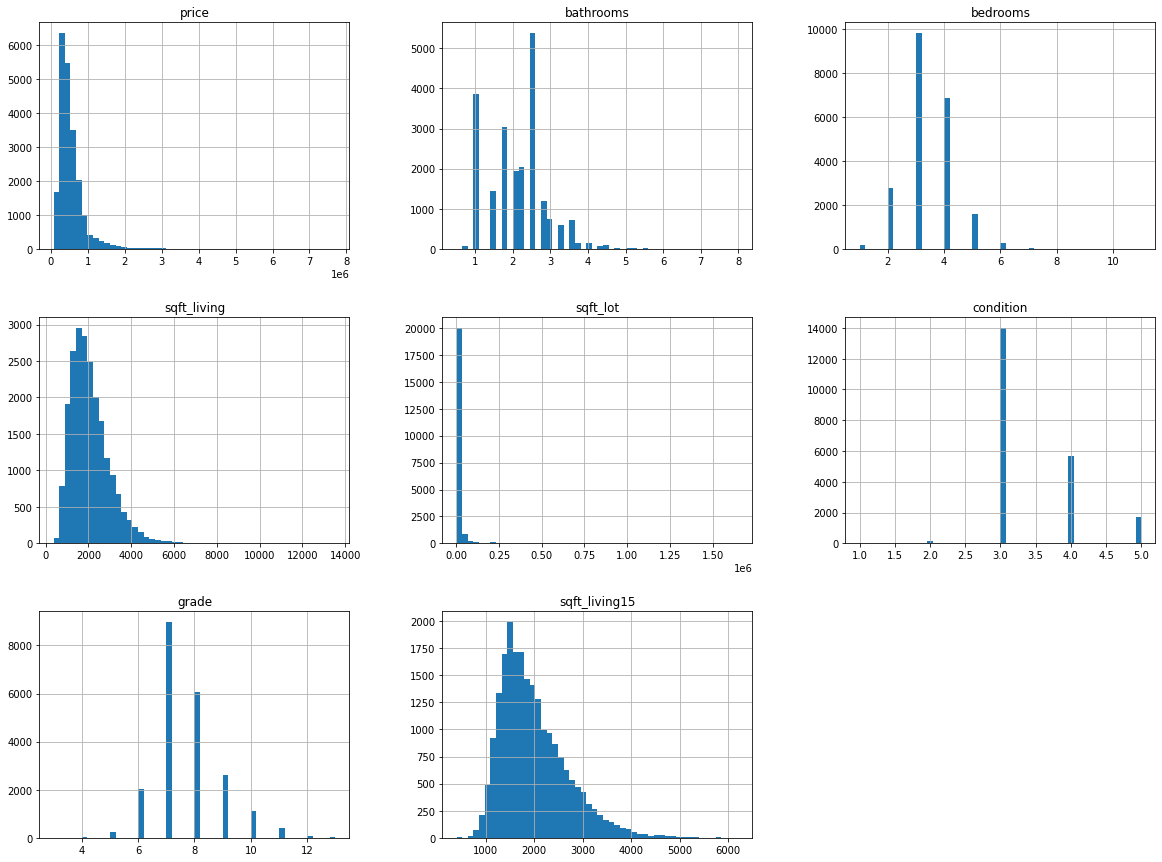

In [3]:
# select most certain variables to take a closer look at
columns_intrest = ['price', 'bathrooms', 'bedrooms', 'sqft_living', 'sqft_lot', 'condition', 'grade', 'sqft_living15']

# take a look at the histograms 
df[columns_intrest].hist(bins=50, figsize = (20,15))
plt.show()

First data insigths from the histogram:
- the price, sqft_living and the sqft_living15 show a slight right-skewed distribution
- sqft_lot seems to be disorted by extreme values
- most houses (~9000) have a grade of 7
- most houses have 2.5 bathrooms (0.5 bathroom in America is a room with only a toilet and a tab)
- nearly 10000 houses have 3 bedrooms, this makes 3 bedrooms the most common value for this feature

#### Correlation between variables

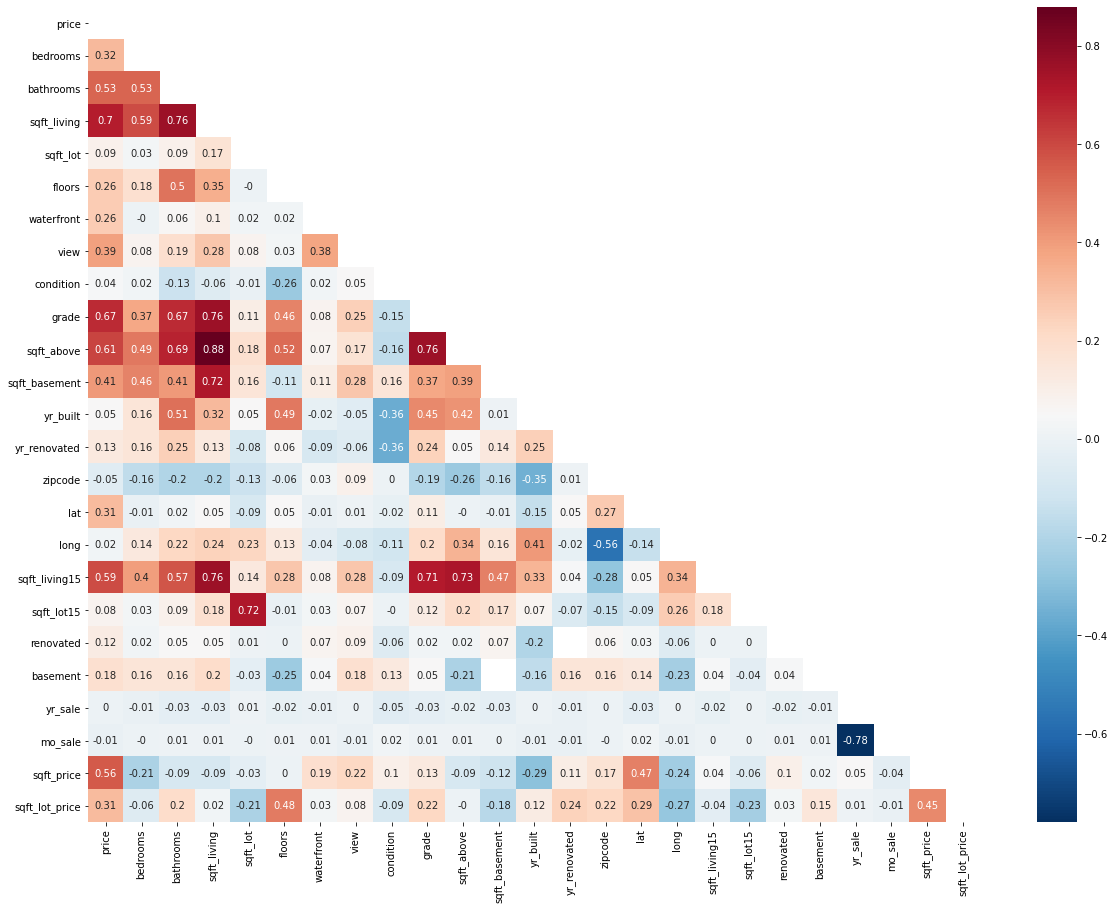

In [4]:
# heatmap of the Pearson correlation coefficients
mask = np.triu(df.corr())
plt.figure(figsize = (20,15))
ax = sns.heatmap(round(df.corr(), 2)
                 ,annot=True
                 ,mask=mask
                 ,cmap='RdBu_r')

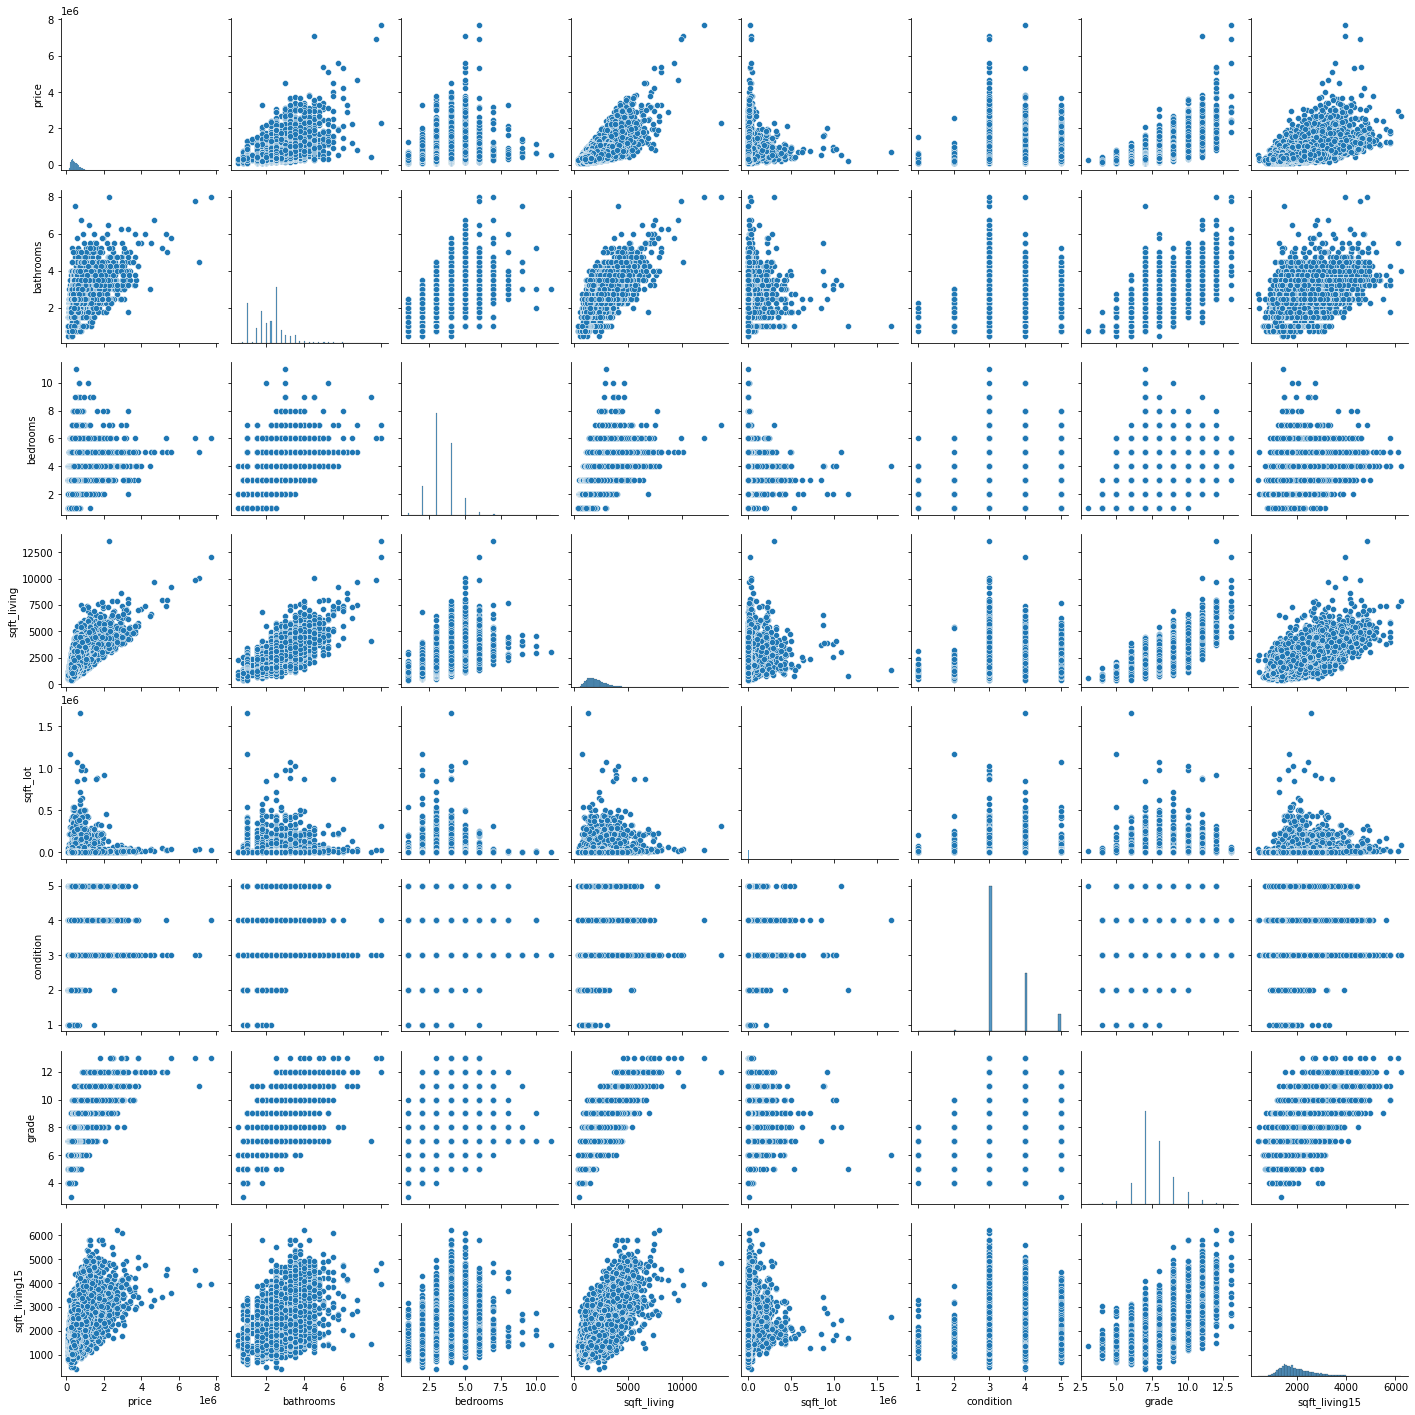

In [5]:
# geting a feeling of the data
df_features = df[columns_intrest]
sns.pairplot(df_features);

## Data Insigths
From these observations the following questions arise:
1. Where is the area with the highes house prices and where with the lowest?
    * Find the area with the highest and lowest prices.
2. Where is the area where the most houses are sold? 
    * Find the area with the most traffic on the housing market.
3. How does your own living space relate to that of the neighbor?
    * Look into the correlation between sqft_living and sqft_living15

### 1. Where is the area with the highes house prices and where with the lowest?  

To find the area with the lowest house prices and the area with the highest house prices I will take the zipcodes as the unit for the  area. As the total prices are affected by the size of the house and the lot, I will use the price per squarefoot (sqft_price) as indicator for the price. The median prices will be used, as the median is not so much affected by extreme values than the mean.

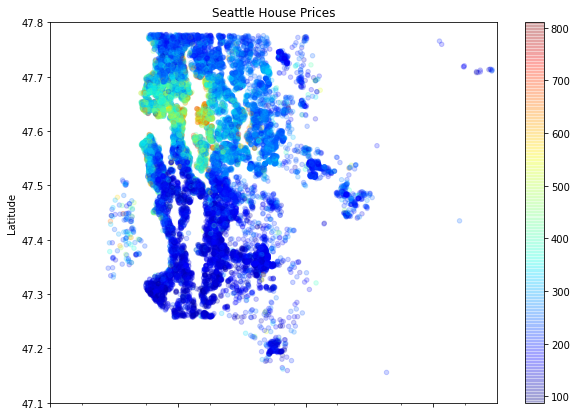

In [98]:
# plot of the the sqft_price over the King Country area
df.plot(kind="scatter",
        x="long", xlabel = "Longitude",
        y="lat", ylabel = "Latitude",
        alpha=0.2, figsize= (10,7), 
        c=df["sqft_price"],cmap=plt.get_cmap("jet"),colorbar = True, 
        xlim = ( -122.7,-121.3), ylim = (47.1, 47.8),
        xticks = list(np.linspace(-122.7, -121.1, 5)),
        legend = False,
        title = "Seattle House Prices");

In [59]:
# how many different zipcodes are in the dataset?
len(df.zipcode.unique()) 

70

In [100]:
# create a dataframe with only price and zipcode
df_zipcodes = df[['sqft_price', 'zipcode']]

# group dataframe by zipcodes and get the median price for each zipcode
zip_median = df_zipcodes.groupby('zipcode').median()

# get the 10 zipcodes with the highest median and those with the lowest
zip_median_top = zip_median.sort_values('sqft_price', ascending=False)[:10]
zip_median_low = zip_median.sort_values('sqft_price')[:10]

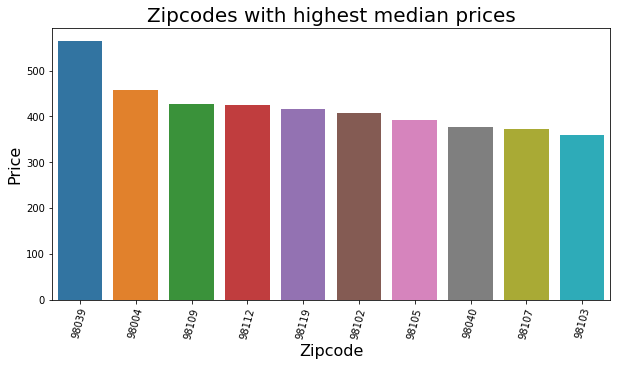

In [102]:
# plot the zip_median_top
fig, ax = plt.subplots(figsize = (10,5))
sns.barplot(y=zip_median_top.sqft_price, x=zip_median_top.index,
           order=zip_median_top.sort_values('sqft_price',ascending = False).index)
plt.xticks(rotation='75');
ax.set_ylabel('Price per squarefoot', fontsize = 16)
ax.set_xlabel('Zipcode', fontsize = 16)
ax.set_title('Zipcodes with highest median prices', fontsize = 20)
plt.xticks(rotation='75');

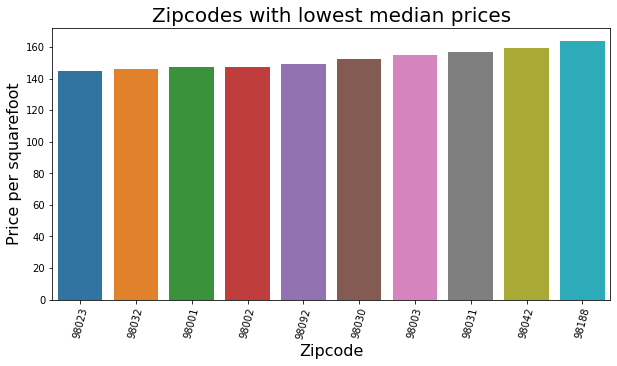

In [103]:
# plot the zip_median_low
fig, ax = plt.subplots(figsize = (10,5))
sns.barplot(y=zip_median_low.sqft_price, x=zip_median_low.index,
           order=zip_median_low.sort_values('sqft_price').index)
ax.set_ylabel('Price per squarefoot', fontsize = 16)
ax.set_xlabel('Zipcode', fontsize = 16)
ax.set_title('Zipcodes with lowest median prices', fontsize = 20)
plt.xticks(rotation='75');

#### Conclusion
The area with the highest median house prices is the zipcode 98039 with an price per squarefoot over 550 Dollar. The area with the lowest median house prices is the zipcode 98023 with an price per squarefoot about 140 Dollar.

### 2. Where is the area where the most houses are sold?
To find the area with the most traffic on the housing market (meaning the area where the most houses are sold) I will again take the zipcodes as the unit for the  area. As indicator for the sold houses I will take the number of sold houses. 

In [19]:
# create a dataframe with only price and zipcode
df_zipcodes = df[['price', 'zipcode']]

# group dataframe by zipcodes and get the median price for each zipcode
zip_count = df_zipcodes.groupby('zipcode').count()

# get the 10 zipcodes with the most sold houses
zip_count = zip_count.sort_values('price', ascending=False)[:10]

# convert the column name into sold_houses as they are now not the prices anymore
zip_count.rename(columns={'price': 'sold_houses'}, inplace=True)

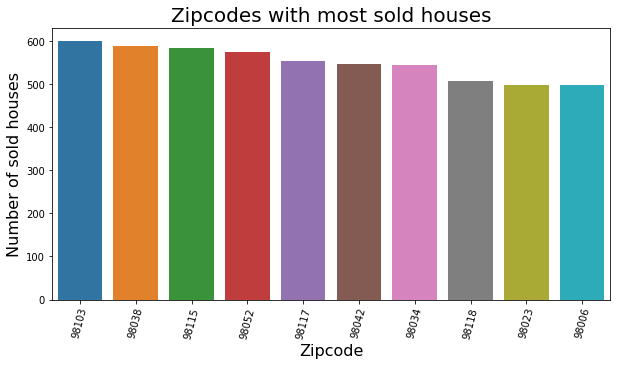

In [18]:
# plot the zip_median_low
fig, ax = plt.subplots(figsize = (10,5))
sns.barplot(y=zip_count.sold_houses, x=zip_count.index,
           order=zip_count.sort_values('sold_houses', ascending=False).index)
ax.set_ylabel('Number of sold houses', fontsize = 16)
ax.set_xlabel('Zipcode', fontsize = 16)
ax.set_title('Zipcodes with most sold houses', fontsize = 20)
plt.xticks(rotation='75');

#### Conclusion
The area with the most traffic on the house market is the zipcode 98103 with almost 600 sold houses in one year. 

### 3. How does your own living space relate to that of the neighbor?
In the pairplot and the correlations we saw that `sqft_living15` and `sqft_living` are positively correlated. So the size of the living seems to be similar in a neighborhood. Let´s build a linear regression model to see how large the living area of your neighbors are. 

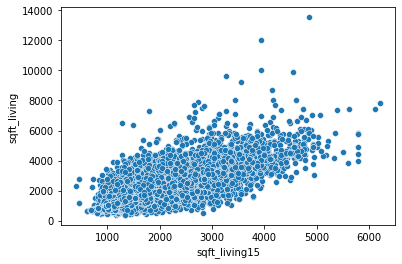

In [35]:
# another look at the scatterplot
sns.scatterplot(x='sqft_living15', y='sqft_living', data=df);

In [29]:
# linear regreession model of sqft_living and sqft_living15
model_neighbor = smf.ols(formula = 'sqft_living ~ sqft_living15', data=df)
results_model_neighbor = model_neighbor.fit()
results_model_neighbor.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            sqft_living   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                 2.888e+04
Date:                Mon, 21 Jun 2021   Prob (F-statistic):               0.00
Time:                        08:23:29   Log-Likelihood:            -1.6881e+05
No. Observations:               21596   AIC:                         3.376e+05
Df Residuals:                   21594   BIC:                         3.376e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        66.9164     12.534      5.339      0.000      42.350      91.483
sqft_living15     1.0135      0.006    169.929      0.000       1.002       1.025
==============================================================================
Omnibus:                     9123.579   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           106332.367
Skew:                           1.710   Prob(JB):                         0.00
Kurtosis:                      13.318   Cond. No.                     6.45e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

1.0134779577813136


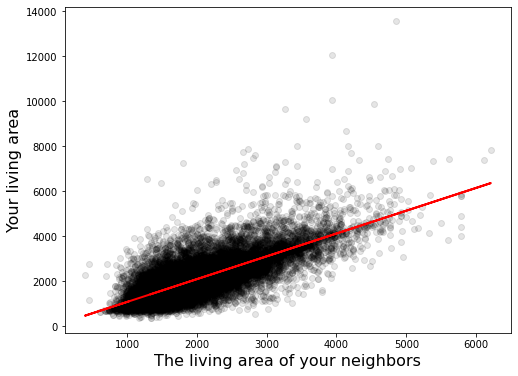

In [34]:
intercept, slope = results_model_neighbor.params

# Plotting the results of the model
fig, ax = plt.subplots(figsize=(8, 6))
x = df.sqft_living15
y = df.sqft_living
# add data points
ax.scatter(x, y, alpha=0.1, color='black')
# plotting regression line
ax.plot(x, x*slope +intercept, '-', color='red', linewidth=2);
ax.set_ylabel("Your living area", fontsize=16);
ax.set_xlabel("The living area of your neighbors", fontsize=16);

print(slope)
fig.savefig('neighbors.png', format='png',dpi=150) 

In [37]:
# what is the intercept?
print(slope)

1.0134779577813136


#### Conclusion
The size of the living seems to be similar in a neighborhood. With every squarefoot of the living area in your neigborhood the living area of your house increases by 1.0134 squarefoot.